In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import gc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2DTranspose, ConvLSTM2D, TimeDistributed, Conv2D, LayerNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [5]:
TRAIN_DIR = "../data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 20
MODEL_PATH = "model/model.hdf5"

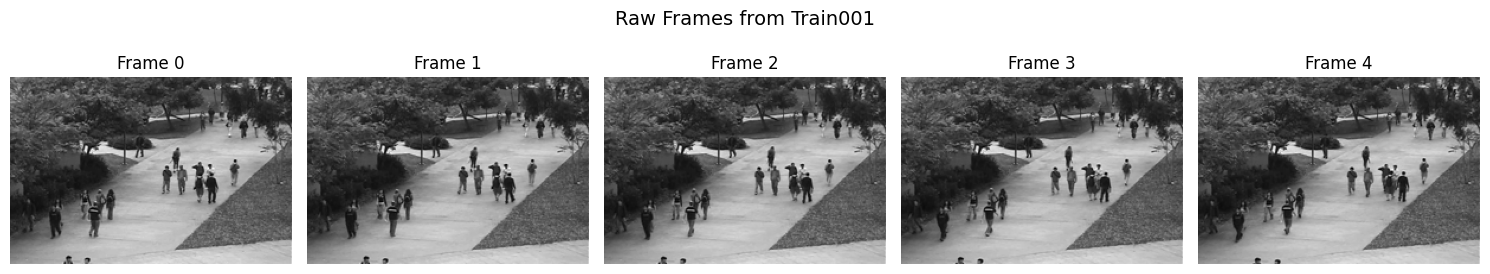

In [6]:
def visualize_frames(folder_dir,folder_name, num_frames=5):
    folder_path = os.path.join(folder_dir, folder_name)
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

    plt.figure(figsize=(15, 3))
    for i in range(num_frames):
        image_path = os.path.join(folder_path, tif_files[i])
        img = cv.imread(image_path, 0)
        
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Frame {i}")
        plt.axis('off')

    plt.suptitle(f"Raw Frames from {folder_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
visualize_frames(TRAIN_DIR, folder_name="Train001", num_frames=5)


### Data Loader

In [ ]:
def preprocess_training_clips(filepath, img_size, frames_per_clip=10):
    all_clips = []

    # Iterate over each subfolder (each video sequence)
    for folder in sorted(os.listdir(filepath)):
        folder_path = os.path.join(filepath, folder)

        if os.path.isdir(folder_path):
            frames = []

            # Read and preprocess each .tif image in the folder
            for file in sorted(os.listdir(folder_path)):
                if file.endswith('.tif'):
                    image_path = os.path.join(folder_path, file)

                    # Read in grayscale, resize, normalize
                    img = cv.imread(image_path, 0)
                    img = cv.resize(img, (img_size, img_size), interpolation=cv.INTER_CUBIC)
                    img = img / 255.0
                    frames.append(img)

            # Create clips using non-overlapping windows of frames_per_clip
            num_frames = len(frames)
            for start in range(0, num_frames - frames_per_clip + 1, frames_per_clip):
                clip = np.zeros((frames_per_clip, img_size, img_size, 1))
                for k in range(frames_per_clip):
                    clip[k, :, :, 0] = frames[start + k]
                all_clips.append(clip)

            # Cleanup memory
            del frames
            gc.collect()

    return np.array(all_clips)
    
training_data = preprocess_training_clips(TRAIN_DIR,IMG_SIZE)

In [ ]:
print(f"Training data shape: {training_data.shape}")

### Model building

In [ ]:
# Encoder
model = Sequential()
model.add(TimeDistributed(Conv2D(128, (6, 6), strides=4, padding='same'), input_shape=(10,224,224,1)))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2D(64, (3, 3), strides=2, padding='same')))
model.add(LayerNormalization())

#bottleneck
model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
model.add(LayerNormalization())
model.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
model.add(LayerNormalization())
model.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
model.add(LayerNormalization())

# Decoder
model.add(TimeDistributed(Conv2DTranspose(64, (3, 3), strides=2, padding='same')))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2DTranspose(128, (6, 6), strides=4, padding='same')))
model.add(LayerNormalization())
model.add(TimeDistributed(Conv2D(1, (5, 5), activation="sigmoid", padding='same')))
print(model.summary())

c:\Users\gaura\OneDrive\Desktop\Projects\Anomaly_Detection\anomaly\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 56, 56,     │         4,736 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 10, 56, 56,     │           256 │
│ (LayerNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 28, 28, 64) │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 10, 28, 28, 64) │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 10, 28, 28, 64) │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 10, 28, 28, 64) │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 10, 28, 28, 32) │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 10, 28, 28, 32) │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 10, 28, 28, 64) │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 10, 28, 28, 64) │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 56, 56, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 10, 56, 56, 64) │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 224, 224,   │       295,040 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 10, 224, 224,   │           256 │
│ (LayerNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 224, 224,   │         3,201 │
│ (TimeDistributed)               │ 1)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,113 (3.98 MB)

 Trainable params: 1,042,113 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
model.compile(loss='mse', optimizer=Adam())
model.fit(training_data, training_data, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False)
model.save(MODEL_PATH)

Epoch 1/20


I0000 00:00:1751388799.727209     101 service.cc:148] XLA service 0x2077c390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751388799.728014     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751388799.728035     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751388801.335970     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751388819.843228     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 95s 688ms/step - loss: 0.0449
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 725ms/step - loss: 0.0087
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 728ms/step - loss: 0.0070
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 731ms/step - loss: 0.0062
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0056
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 731ms/step - loss: 0.0050
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0047
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0043
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 731ms/step - loss: 0.0041
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0038
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0037
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0034
Epoch 13/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0033
Epoch 14/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step - loss: 0.0031
Epoch 15/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 730ms/step 